#Things to notice : 

    1) If running from start , just uncomment everything and run.
    2) Cells that should be commented out if loading model and weights from a path : 
    Cells :
            1) Entire Discriminator Section
            2) Entire Gan Loss section
            3) Entire Pre-training gen. section
            4) Model Initialization 1st cell
            5) Downloading Weights section, if weights have already been downloaded.
            6) Entire section of downloading & loading datasets
            7) 2nd cell of making dataloaders
            8) **Don't Uncomment** : Download Model & Weights from our drive to the PC

# Don't Uncomment any section if you don't know what you are doing.

# Importing Libraries

In [1]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
use_colab = None

In [31]:
from google.colab import drive
drive.mount('/content/gdrive')
drive_model_path = '/content/gdrive/MyDrive/MinorProjectFiles/Model/'
drive_weight_path = '/content/gdrive/MyDrive/MinorProjectFiles/Weight/'
drive_output_path = '/content/gdrive/MyDrive/MinorProjectFiles/Output/'
drive_input_path = '/content/gdrive/MyDrive/MinorProjectFiles/Input/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Install fast ai

In [4]:
# !pip install fastai --upgrade

     |████████████████████████████████| 186 kB 6.4 MB/s 
     |████████████████████████████████| 56 kB 4.6 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


# Downloading Dataset

In [5]:
# from fastai.data.external import untar_data, URLs
# coco_path = untar_data(URLs.COCO_SAMPLE)
# coco_path = str(coco_path) + "/train_sample"
# use_colab = True

#Loading Dataset

In [6]:
# if use_colab == True:
#     path = coco_path
# else:
#     path = "Your path to the dataset"
    
# paths = glob.glob(path + "/*.jpg") # Grabbing all the image file names
# np.random.seed(123)
# paths_subset = np.random.choice(paths, 10_000, replace=False) # choosing 1000 images randomly
# rand_idxs = np.random.permutation(10_000)
# train_idxs = rand_idxs[:8000] # choosing the first 8000 as training set
# val_idxs = rand_idxs[8000:] # choosing last 2000 as validation set
# train_paths = paths_subset[train_idxs]
# val_paths = paths_subset[val_idxs]
# print(len(train_paths), len(val_paths))

8000 2000


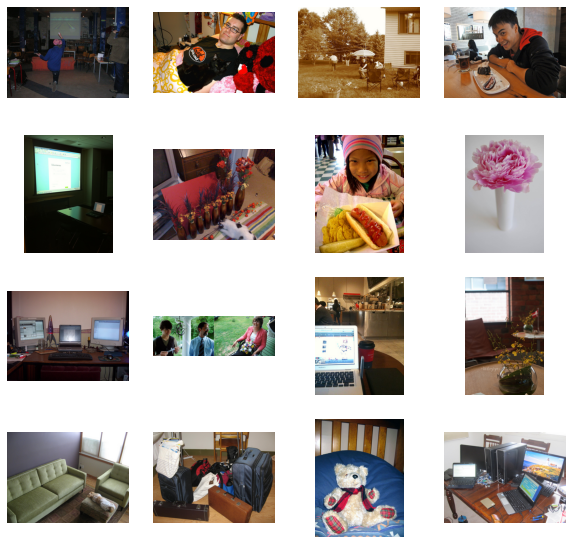

In [7]:
# _, axes = plt.subplots(4, 4, figsize=(10, 10))
# for ax, img_path in zip(axes.flatten(), train_paths):
#     ax.imshow(Image.open(img_path))
#     ax.axis("off")

# Making Dataset & DataLoaders

In [8]:
SIZE = 256
class ColorizationDataset(Dataset):
    def __init__(self, paths, split='train'):
        if split == 'train':
            self.transforms = transforms.Compose([
                transforms.Resize((SIZE, SIZE),  Image.BICUBIC),
                transforms.RandomHorizontalFlip(), # A little data augmentation!
            ])
        elif split == 'val':
            self.transforms = transforms.Resize((SIZE, SIZE),  Image.BICUBIC)
        
        self.split = split
        self.size = SIZE
        self.paths = paths
    
    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        img = self.transforms(img)
        img = np.array(img)
        img_lab = rgb2lab(img).astype("float32") # Converting RGB to L*a*b
        img_lab = transforms.ToTensor()(img_lab)
        L = img_lab[[0], ...] / 50. - 1. # Between -1 and 1
        ab = img_lab[[1, 2], ...] / 110. # Between -1 and 1
        
        return {'L': L, 'ab': ab}
    
    def __len__(self):
        return len(self.paths)

def make_dataloaders(batch_size=16, n_workers=4, pin_memory=True, **kwargs): # A handy function to make our dataloaders
    dataset = ColorizationDataset(**kwargs)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=n_workers,
                            pin_memory=pin_memory)
    return dataloader

In [9]:
# train_dl = make_dataloaders(paths=train_paths, split='train')
# val_dl = make_dataloaders(paths=val_paths, split='val')

# data = next(iter(train_dl))
# Ls, abs_ = data['L'], data['ab']
# print(Ls.shape, abs_.shape)
# print(len(train_dl), len(val_dl))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
500 125


#GENERATOR

In [10]:
from fastai.vision.learner import create_body
from torchvision.models.resnet import resnet18
from fastai.vision.models.unet import DynamicUnet

In [11]:
def build_res_unet(n_input=1, n_output=2, size=256):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    body = create_body(resnet18, pretrained=True, n_in=n_input, cut=-2)
    net_G = DynamicUnet(body, n_output, (size, size)).to(device)
    return net_G

#DISCRIMINATOR

In [12]:
# class PatchDiscriminator(nn.Module):
#     def __init__(self, input_c, num_filters=64, n_down=3):
#         super().__init__()
#         model = [self.get_layers(input_c, num_filters, norm=False)]
#         model += [self.get_layers(num_filters * 2 ** i, num_filters * 2 ** (i + 1), s=1 if i == (n_down-1) else 2) 
#                           for i in range(n_down)] # the 'if' statement is taking care of not using
#                                                   # stride of 2 for the last block in this loop
#         model += [self.get_layers(num_filters * 2 ** n_down, 1, s=1, norm=False, act=False)] # Make sure to not use normalization or
#                                                                                              # activation for the last layer of the model
#         self.model = nn.Sequential(*model)                                                   
        
#     def get_layers(self, ni, nf, k=4, s=2, p=1, norm=True, act=True): # when needing to make some repeatitive blocks of layers,
#         layers = [nn.Conv2d(ni, nf, k, s, p, bias=not norm)]          # it's always helpful to make a separate method for that purpose
#         if norm: layers += [nn.BatchNorm2d(nf)]
#         if act: layers += [nn.LeakyReLU(0.2, True)]
#         return nn.Sequential(*layers)
    
#     def forward(self, x):
#         return self.model(x)

In [13]:
# DISCRIMINATOR BLOCKS
# PatchDiscriminator(3)

PatchDiscriminator(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (2): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (3): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2, inplace=True)
    )
    (

In [14]:
# # DISCRIMINATOR OUTPUT SHAAPE
# discriminator = PatchDiscriminator(3)
# dummy_input = torch.randn(16, 3, 256, 256) # batch_size, channels, size, size
# out = discriminator(dummy_input)
# out.shape

torch.Size([16, 1, 30, 30])

#GAN LOSS (VANILLA)

In [15]:
# class GANLoss(nn.Module):
#     def __init__(self, gan_mode='vanilla', real_label=1.0, fake_label=0.0):
#         super().__init__()
#         self.register_buffer('real_label', torch.tensor(real_label))
#         self.register_buffer('fake_label', torch.tensor(fake_label))
#         if gan_mode == 'vanilla':
#             self.loss = nn.BCEWithLogitsLoss()
#         elif gan_mode == 'lsgan':
#             self.loss = nn.MSELoss()
    
#     def get_labels(self, preds, target_is_real):
#         if target_is_real:
#             labels = self.real_label
#         else:
#             labels = self.fake_label
#         return labels.expand_as(preds)
    
#     def __call__(self, preds, target_is_real):
#         labels = self.get_labels(preds, target_is_real)
#         loss = self.loss(preds, labels)
#         return loss

# Useful Functions

In [16]:
# Utility function to visualize the training process
class AverageMeter:
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.count, self.avg, self.sum = [0.] * 3
    
    def update(self, val, count=1):
        self.count += count
        self.sum += count * val
        self.avg = self.sum / self.count

def create_loss_meters():
    loss_D_fake = AverageMeter()
    loss_D_real = AverageMeter()
    loss_D = AverageMeter()
    loss_G_GAN = AverageMeter()
    loss_G_L1 = AverageMeter()
    loss_G = AverageMeter()
    
    return {'loss_D_fake': loss_D_fake,
            'loss_D_real': loss_D_real,
            'loss_D': loss_D,
            'loss_G_GAN': loss_G_GAN,
            'loss_G_L1': loss_G_L1,
            'loss_G': loss_G}

def update_losses(model, loss_meter_dict, count):
    for loss_name, loss_meter in loss_meter_dict.items():
        loss = getattr(model, loss_name)
        loss_meter.update(loss.item(), count=count)

def lab_to_rgb(L, ab):
    """
    Takes a batch of images
    """
    
    L = (L + 1.) * 50.
    ab = ab * 110.
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).cpu().numpy()
    rgb_imgs = []
    for img in Lab:
        img_rgb = lab2rgb(img)
        rgb_imgs.append(img_rgb)
    return np.stack(rgb_imgs, axis=0)
    
def visualize(model, data, save=True):
    model.net_G.eval()
    with torch.no_grad():
        model.setup_input(data)
        model.forward()
    model.net_G.train()
    fake_color = model.fake_color.detach()
    real_color = model.ab
    L = model.L
    fake_imgs = lab_to_rgb(L, fake_color)
    real_imgs = lab_to_rgb(L, real_color)
    fig = plt.figure(figsize=(15, 8))
    for i in range(5):
        # ax = plt.subplot(3, 5, i + 1)
        # ax.imshow(L[i][0].cpu(), cmap='gray')
        # ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 5)
        ax.imshow(fake_imgs[i])
        ax.axis("off")
        ax = plt.subplot(3, 5, i + 1 + 10)
        ax.imshow(real_imgs[i])
        ax.axis("off")
    plt.show()
    if save:
        fig.savefig(f"{drive_output_path}colorization_{time.time()}.png")
        
def log_results(loss_meter_dict):
    for loss_name, loss_meter in loss_meter_dict.items():
        print(f"{loss_name}: {loss_meter.avg:.5f}")

# Pre-Training Generator 

In [20]:

# def pretrain_generator(net_G, train_dl, opt, criterion, epochs):
#     for e in range(epochs):
#         loss_meter = AverageMeter()
#         for data in tqdm(train_dl):
#             L, ab = data['L'].to(device), data['ab'].to(device)
#             preds = net_G(L)
#             loss = criterion(preds, ab)
#             opt.zero_grad()
#             loss.backward()
#             opt.step()
            
#             loss_meter.update(loss.item(), L.size(0))
            
#         print(f"Epoch {e + 1}/{epochs}")
#         print(f"L1 Loss: {loss_meter.avg:.5f}")

# net_G = build_res_unet(n_input=1, n_output=2, size=256)
# opt = optim.Adam(net_G.parameters(), lr=1e-4)
# criterion = nn.L1Loss()        
# pretrain_generator(net_G, train_dl, opt, criterion, 20)
# torch.save(net_G.state_dict(), f"{drive_model_path}res18-unet.pt")

  0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch 1/20
L1 Loss: 0.08661


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 2/20
L1 Loss: 0.08337


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 3/20
L1 Loss: 0.08279


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 4/20
L1 Loss: 0.08228


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 5/20
L1 Loss: 0.08183


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 6/20
L1 Loss: 0.08140


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 7/20
L1 Loss: 0.08086


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 8/20
L1 Loss: 0.08031


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 9/20
L1 Loss: 0.07951


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 10/20
L1 Loss: 0.07887


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 11/20
L1 Loss: 0.07795


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 12/20
L1 Loss: 0.07726


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 13/20
L1 Loss: 0.07627


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 14/20
L1 Loss: 0.07526


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 15/20
L1 Loss: 0.07438


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 16/20
L1 Loss: 0.07328


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 17/20
L1 Loss: 0.07222


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 18/20
L1 Loss: 0.07139


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 19/20
L1 Loss: 0.07071


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 20/20
L1 Loss: 0.06977


# Model Initialization

In [21]:
# def init_weights(net, init='norm', gain=0.02):
    
#     def init_func(m):
#         classname = m.__class__.__name__
#         if hasattr(m, 'weight') and 'Conv' in classname:
#             if init == 'norm':
#                 nn.init.normal_(m.weight.data, mean=0.0, std=gain)
#             elif init == 'xavier':
#                 nn.init.xavier_normal_(m.weight.data, gain=gain)
#             elif init == 'kaiming':
#                 nn.init.kaiming_normal_(m.weight.data, a=0, mode='fan_in')
            
#             if hasattr(m, 'bias') and m.bias is not None:
#                 nn.init.constant_(m.bias.data, 0.0)
#         elif 'BatchNorm2d' in classname:
#             nn.init.normal_(m.weight.data, 1., gain)
#             nn.init.constant_(m.bias.data, 0.)
            
#     net.apply(init_func)
#     print(f"model initialized with {init} initialization")
#     return net

# def init_model(model, device):
#     model = model.to(device)
#     model = init_weights(model)
#     return model

In [22]:
class MainModel(nn.Module):
    def __init__(self, net_G=None, lr_G=2e-4, lr_D=2e-4, 
                 beta1=0.5, beta2=0.999, lambda_L1=100.):
        super().__init__()
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.lambda_L1 = lambda_L1
        
        if net_G is None:
            self.net_G = init_model(Unet(input_c=1, output_c=2, n_down=8, num_filters=64), self.device)
        else:
            self.net_G = net_G.to(self.device)
        self.net_D = init_model(PatchDiscriminator(input_c=3, n_down=3, num_filters=64), self.device)
        self.GANcriterion = GANLoss(gan_mode='vanilla').to(self.device)
        self.L1criterion = nn.L1Loss()
        self.opt_G = optim.Adam(self.net_G.parameters(), lr=lr_G, betas=(beta1, beta2))
        self.opt_D = optim.Adam(self.net_D.parameters(), lr=lr_D, betas=(beta1, beta2))
    
    def set_requires_grad(self, model, requires_grad=True):
        for p in model.parameters():
            p.requires_grad = requires_grad
        
    def setup_input(self, data):
        self.L = data['L'].to(self.device)
        self.ab = data['ab'].to(self.device)
        
    def forward(self):
        self.fake_color = self.net_G(self.L)
    
    def backward_D(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image.detach())
        self.loss_D_fake = self.GANcriterion(fake_preds, False)
        real_image = torch.cat([self.L, self.ab], dim=1)
        real_preds = self.net_D(real_image)
        self.loss_D_real = self.GANcriterion(real_preds, True)
        self.loss_D = (self.loss_D_fake + self.loss_D_real) * 0.5
        self.loss_D.backward()
    
    def backward_G(self):
        fake_image = torch.cat([self.L, self.fake_color], dim=1)
        fake_preds = self.net_D(fake_image)
        self.loss_G_GAN = self.GANcriterion(fake_preds, True)
        self.loss_G_L1 = self.L1criterion(self.fake_color, self.ab) * self.lambda_L1
        self.loss_G = self.loss_G_GAN + self.loss_G_L1
        self.loss_G.backward()
    
    def optimize(self):
        self.forward()
        self.net_D.train()
        self.set_requires_grad(self.net_D, True)
        self.opt_D.zero_grad()
        self.backward_D()
        self.opt_D.step()
        
        self.net_G.train()
        self.set_requires_grad(self.net_D, False)
        self.opt_G.zero_grad()
        self.backward_G()
        self.opt_G.step()

# Downloading Weights

In [23]:
# !gdown --id 1lR6DcS4m5InSbZ5y59zkH2mHt_4RQ2KV

Downloading...
From: https://drive.google.com/uc?id=1lR6DcS4m5InSbZ5y59zkH2mHt_4RQ2KV
To: /content/final_model_weights.pt
136MB [00:02, 51.8MB/s]


# Download Model & Weights from our drive to the PC
Don't Uncomment it.

In [ ]:
# from google.colab import files
# files.download( path )

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Loading Weights

In [29]:
net_G = build_res_unet(n_input=1, n_output=2, size=256)
net_G.load_state_dict(torch.load(f"{drive_model_path}res18-unet.pt", map_location=device))
model = MainModel(net_G=net_G)
model.load_state_dict(torch.load(f"{drive_weight_path}final_model_weights.pt", map_location=device))

model initialized with norm initialization


<All keys matched successfully>

In [30]:
import matplotlib.pyplot as plt

# Uploading our images for testing

['/content/gdrive/MyDrive/MinorProjectFiles/Input/2.jpg', '/content/gdrive/MyDrive/MinorProjectFiles/Input/4.jpg', '/content/gdrive/MyDrive/MinorProjectFiles/Input/3.jpg', '/content/gdrive/MyDrive/MinorProjectFiles/Input/1.jpg', '/content/gdrive/MyDrive/MinorProjectFiles/Input/5.jpg']


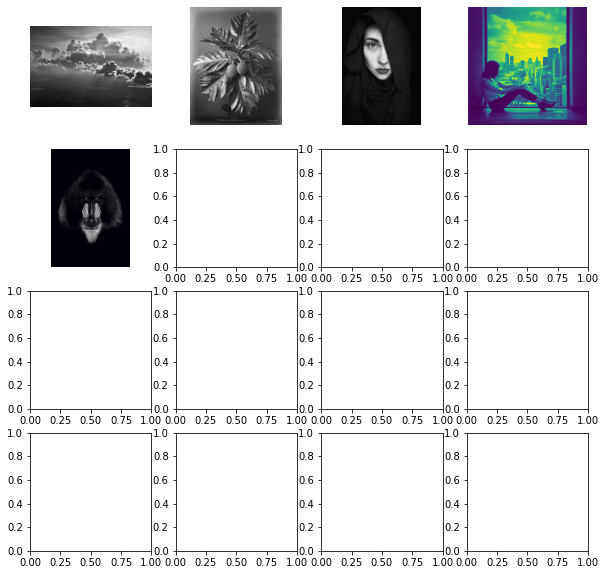

In [36]:
folder_path = drive_input_path
img_paths = glob.glob(folder_path + "/*.jpg")
print(img_paths)
_, axes = plt.subplots(4, 4, figsize=(10, 10))
for ax, img_path in zip(axes.flatten(), img_paths):
    ax.imshow(Image.open(img_path))
    ax.axis("off")

In [37]:
testing_dl = make_dataloaders(paths=img_paths, split='val')

testing_data = next(iter(testing_dl))

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Final Output on our Images

/usr/local/lib/python3.7/dist-packages/skimage/color/colorconv.py:1068: UserWarning: Color data out of range: Z < 0 in 5 pixels
  return xyz2rgb(lab2xyz(lab, illuminant, observer))


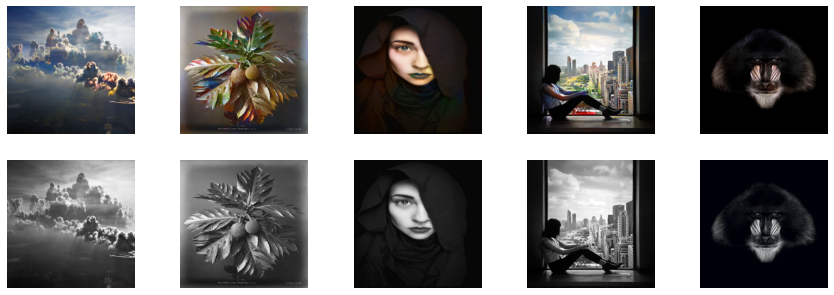

In [38]:
visualize(model, testing_data)